In [1]:
import pandas as pd
import json
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [3]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')

In [4]:
df = (price.merge(apartment, how='left', on='apartment_id').
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left', on='apartment_id'))

In [5]:
df.head()

,price_id,apartment_id,area,period,year,month,amount,amount_original,district_id,apartment_addr_town,...,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,1,8928,160㎡,2020.02,2020,2,2060000000,"20억 6,000",1,개포동,...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316,학여울역,0.002592,1
1,2,8928,160㎡,2020.01,2020,1,2030000000,"20억 3,000",1,개포동,...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316,학여울역,0.002592,1
2,3,8928,160㎡,2019.11,2019,11,1950000000,"19억 5,000",1,개포동,...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316,학여울역,0.002592,1
3,4,8928,160㎡,2019.10,2019,10,1939999999,"19억 4,000",1,개포동,...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316,학여울역,0.002592,1
4,5,8928,160㎡,2019.07,2019,7,1739999999,"17억 4,000",1,개포동,...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316,학여울역,0.002592,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457904 entries, 0 to 457903
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   price_id               457904 non-null  int64  
 1   apartment_id           457904 non-null  int64  
 2   area                   457904 non-null  object 
 3   period                 457904 non-null  object 
 4   year                   457904 non-null  int64  
 5   month                  457904 non-null  int64  
 6   amount                 457904 non-null  int64  
 7   amount_original        457904 non-null  object 
 8   district_id            457904 non-null  int64  
 9   apartment_addr_town    457904 non-null  object 
 10  apartment_builder      457904 non-null  object 
 11  apartment_build_year   457904 non-null  int64  
 12  apartment_build_month  457904 non-null  int64  
 13  apartment_floor_min    457904 non-null  object 
 14  apartment_floor_max    457904 non-nu

## 1. 데이터 분석을 위한 기본적인 데이터 전처리
### 1) 분석에 용이하도록 object변수 변환

In [7]:
# school_Students를 숫자형 변수로 바꿔준다
df['school_students'] = pd.to_numeric(df['school_students'])

In [8]:
# area에서 숫자가 아닌 부분을 제거해준다 
import re
df['area'] = df['area'].apply(lambda x: int(re.split('\D',x)[0]))

In [9]:
df['school_addr_town'].head(1)

0    개포로109길
Name: school_addr_town, dtype: object

In [10]:
#'school_addr_town'에서 ~길의 내용을 제거하고 ~로까지 확인한다 
import re
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: re.split('\d',x)[0])

# chool_addr_town'에서 '로' 를 '동'으로 바꿔준다 
df['school_addr_town'] = df['school_addr_town'].apply(lambda x: x.replace('로','동'))

### 2) null값 확인

In [11]:
df.isnull().any()

price_id                 False
apartment_id             False
area                     False
period                   False
year                     False
month                    False
amount                   False
amount_original          False
district_id              False
apartment_addr_town      False
apartment_builder        False
apartment_build_year     False
apartment_build_month    False
apartment_floor_min      False
apartment_floor_max      False
apartment_parking        False
apartment_name           False
district_name            False
school_name              False
school_dist              False
school_addr_district     False
school_addr_town         False
school_students           True
st_name                  False
st_dist                  False
st_volume                False
dtype: bool

- 학교 학생수에 null값이 발생

In [12]:
df = df.fillna(0)

### 3) 이상치 제거
- 실거래가를 자치구별로 나타내고 이상치 제거

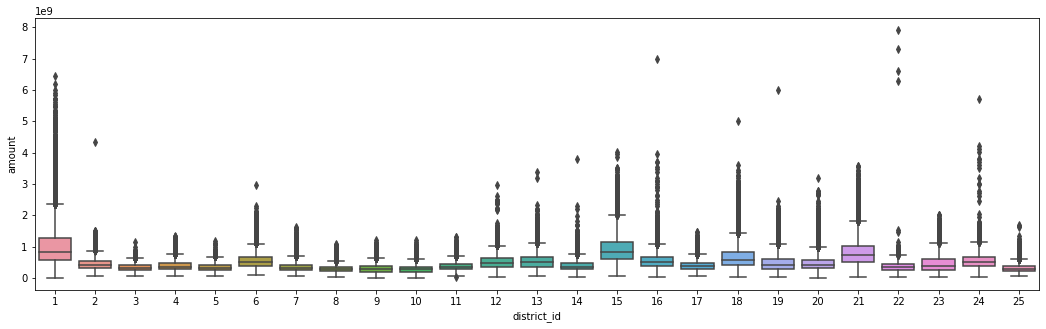

In [13]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

- 이상치는 동일 면적의 해당 아파트 거래가 한번인 경우 제거하지 않았다
- 해당 아파트에 대한 거래 정보가 없어지기 때문

In [14]:
#이상치 제거
df.drop(df[df['district_id']==2].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==6].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==12].sort_values(by='amount',ascending=False).head(5).index,inplace=True)
#df.drop(df[df['district_id']==13].sort_values(by='amount',ascending=False).head(2).index,inplace=True) 거래가 총 2번 이루어져서 제거 안함
df.drop(df[df['district_id']==14].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==16].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==18].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==19].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==22].sort_values(by='amount',ascending=False).head(3).index,inplace=True)#신호아파트 면적97인 아파트의 경우 한번 거래가 이루어져 제거 안함
df.drop(df[df['district_id']==24].sort_values(by='amount',ascending=False).head(1).index,inplace=True)

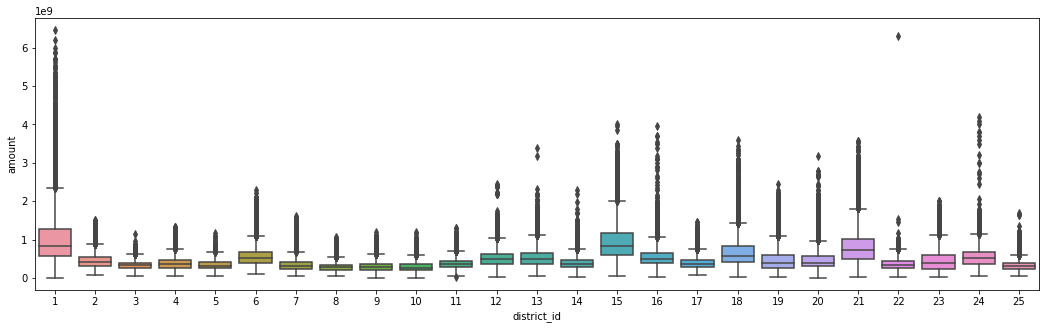

In [15]:
#이상치를 제거한 boxplot
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

## 2. 아파트 별 거래분포 확인

In [16]:
# 폰트 설정 
import matplotlib.font_manager as fm

path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

%matplotlib inline

### 아파트 ID 개수
- 몇 종류의 아파트가 있을까?

In [17]:
n_apt = len(df['apartment_id'].unique())
print(f'서울특별시에는 {n_apt} 종류의 아파트(ID)가 있다.')

서울특별시에는 5683 종류의 아파트(ID)가 있다.


### 아파트 ID별 거래량
- 그동안 아파트 ID별 몇 건의 거래가 있었을까?

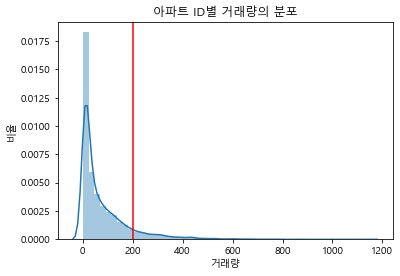

총 거래량이 200번 이하인 아파트 ID가 전체에서 89%의 비율을 차지


In [18]:
apt_count = df['apartment_id'].value_counts().to_frame('count') # 아파트 ID별 거래량(count) 
graph_1 = sns.distplot(apt_count) # 그래프
graph_1.axvline(200, color='red') # 수직선
plt.title('아파트 ID별 거래량의 분포')
plt.xlabel('거래량'); plt.ylabel('비율')
plt.show()
print(f"총 거래량이 200번 이하인 아파트 ID가 전체에서 {round(len(apt_count[apt_count['count']<=200])/n_apt*100)}%의 비율을 차지")

### 아파트 ID별 거래월별 분포
- 아파트 매매 거래는 주거의 목적을 내포하고 있기 때문에 거래일자의 분포가 촘촘하지 않을 수 있다. 실제로 그런지 확인하기 위해 EDA를 실행한다.

#### 총 거래월 수
- 자료의 최소 시간 단위는 '월(month)'로 구성되어 있다.

In [19]:
n_period = len(df['period'].unique())
print(f"{df['period'].min()}부터 {df['period'].max()}까지 총 {n_period}의 개월로 분포한다.")

2006.01부터 2020.04까지 총 172의 개월로 분포한다.


#### 거래 없는 달의 분포
- 아파트 ID별로 거래가 아예 없는 월이 있을 것으로 생각된다. 이를 확인해보도록 한다.

In [20]:
apt_per = (df[['apartment_id','period']].drop_duplicates(). # 아파트 ID별로 몇 개의 기간이 있는가
           groupby('apartment_id')['period'].count().to_frame('count').reset_index() # 있는 기간은 총 몇 개인가
          )
apt_per['count'] = 172 - apt_per['count'] # 총 개월 수에서 빼주면 결측값

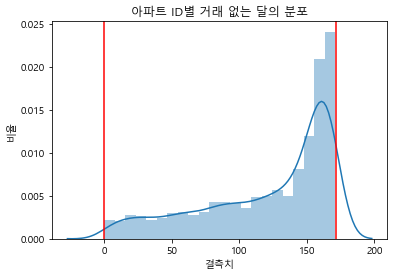

In [21]:
graph_2 = sns.distplot(apt_per['count']) # 그래프
graph_2.axvline(0, color='red') # 최소
graph_2.axvline(172, color='red') # 최대
plt.title('아파트 ID별 거래 없는 달의 분포')
plt.xlabel('결측치'); plt.ylabel('비율')
plt.show()

- 아파트 별로 거래가 발생하지 않는 달이 많다. 매매가의 예측값을 알고싶더라고, 샘플이 거의 없어 예측이 불가능하다. 이에 따라 클러스터링 기법을 사용해서 샘플의 수를 인위적으로 늘리고자 한다

## 3. Feature selecting & 데이터 분석 
- 클러스터링에 사용할 변수를 선택하기 위해 각 변수와 amount의 상관관계 파악에 중점을 두어 분석 
- 데이터의 분포와 값을 살펴보면서 데이터에 대한 이해 증진 
- 변수는 크게 5가지로 나누어 살펴볼 것

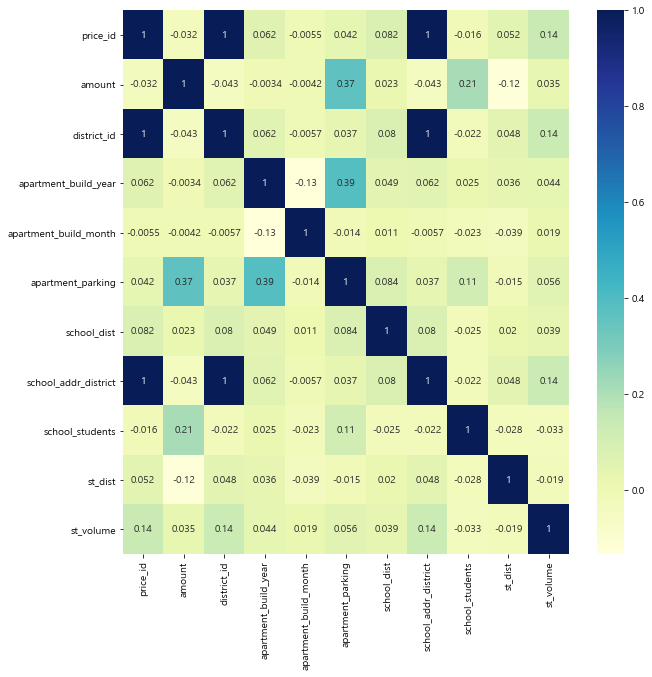

In [22]:
# 시계열에만 사용될 변수를 제거하고 heatmap을 사용해 상관관계를 살펴보았다
temp = df.drop(['apartment_id','area','year','month'],axis=1)
figure,ax1 = plt.subplots()
figure.set_size_inches(10,10)

sns.heatmap(temp.corr(),annot=True,cmap='YlGnBu')

- 수치상으로 'apartment_parking' 'school_students' 'st_dist'변수가 상대적으로 amount값과 높은 상관관계를 보인다
- 각 변수별로 자세히 알아보자

### 1) 연도별 거래액

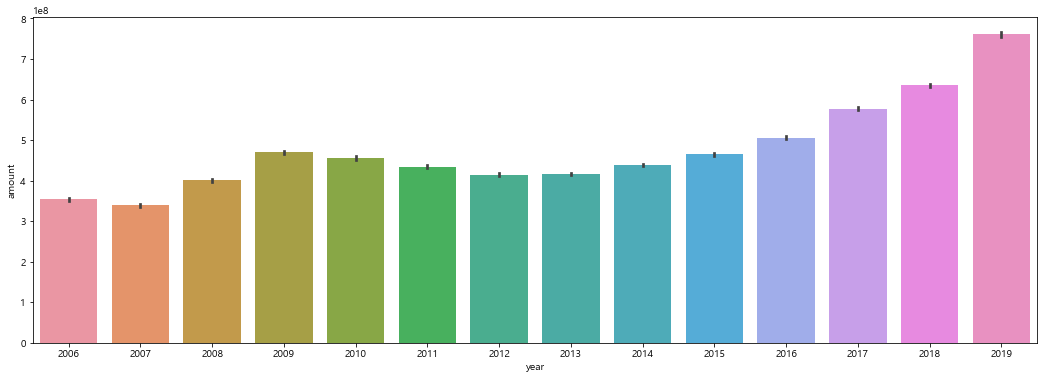

In [23]:
#2020년도의 경우 6월달까지의 거래액만 존재해서 제외
a = df[df['year']<2020]
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 

sns.barplot(data=a,x="year",y="amount",ax=ax1)

- 2009년도부터 2013년까지의 실거래가가 감소하나, 2013년도부터 실거래가 증가

### 2) 학교정보

In [24]:
df['school_name'].nunique()

538

- 538개의 학교가 있으며, 초등학교 데이터만 존재 

#### 학교이름 school_id
- 학교 id에 따른 2019년도의 거래가를 구해서 거래가의 분포를 살펴보았다 

In [25]:
sample = df[df['school_students']>0]
sample = sample.groupby(['school_name','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,school_name,year,amount
13,서울가곡초등학교,2019,7.871852e+08
28,서울가동초등학교,2019,9.587981e+08
43,서울가락초등학교,2019,1.119956e+09
58,서울가산초등학교,2019,4.142600e+08
73,서울가양초등학교,2019,5.781785e+08


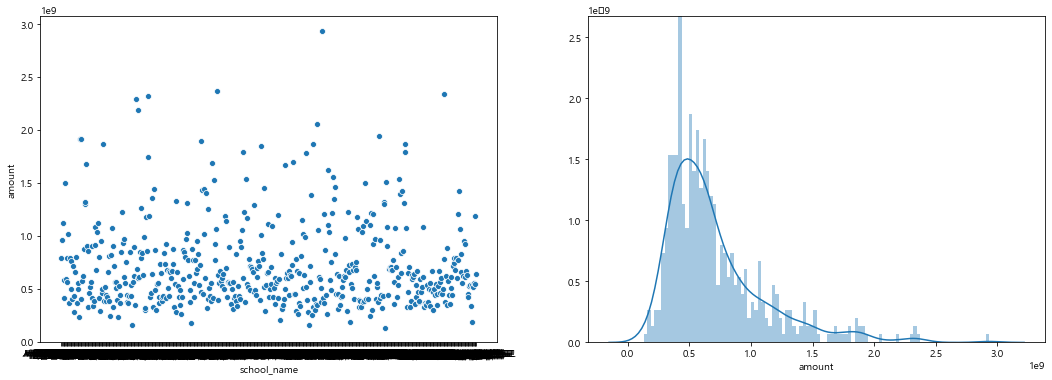

In [26]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.scatterplot(sample_2019['school_name'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=100)

- 가격의 분포가 5억을 중심으로 정규분포에 근사하며, 학교에 따라 다양한 값을 가짐

#### 학교 주소

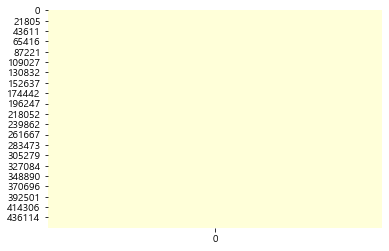

In [27]:
a = df['school_addr_district']==df['district_id']
a = pd.DataFrame(a)
sns.heatmap(a,cbar=False, cmap="YlGnBu")

- 'school_add_district'와'district_id' 값이 모두 동일하므로 제거한다 

#### 아파트에서 가장 가까운 학교까지의 거리 school_dist

In [28]:
df['school_dist'].max()

29

- 아파트에서 가장 가까운 학교까지의 거리는 최대 도보 29분

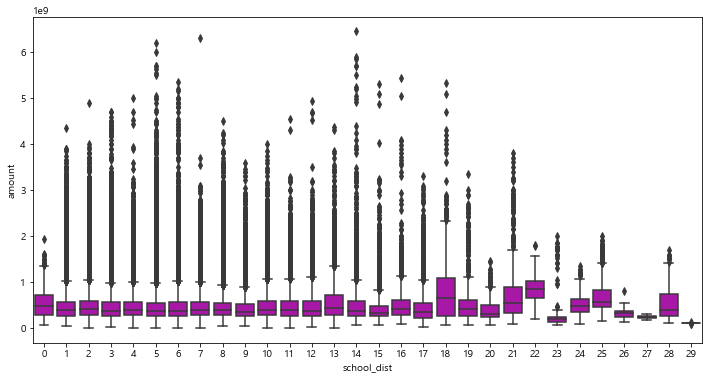

In [29]:
figure,ax1 = plt.subplots()
figure.set_size_inches(12,6) 

sns.boxplot(x="school_dist",y="amount",data=df,color="m",ax=ax1)

- 아파트에서 학교까지의 거리에 따른 amount값이 큰 차이를 보이지 않는다. 특히 17분 이하의 경우에는 거의 동일한 box plot을 갖는다 -- 제거
- heatmap의 0.023 수치에서도 확인 가능

#### 학교 학생수 school_Students

In [30]:
ind = df[df['school_name']=='서울가산초등학교'].index
temp = df.drop(ind)
# 서울가산초등학교의 경우 데이터에 따라 금천구 구로구에 모두 속한다고 표기되어 있음 제거해준다

In [31]:
temp = temp.groupby('school_name').mean()[['school_students','amount']].dropna()
temp = pd.merge(temp,df[['district_name','school_name']],how='left',on='school_name').drop_duplicates().reset_index()
temp.head()

,index,school_name,school_students,amount,district_name
0,0,,0.0,5.449626e+08,강동구
1,310,,0.0,5.449626e+08,강북구
2,336,,0.0,5.449626e+08,강서구
3,341,,0.0,5.449626e+08,광진구
4,362,,0.0,5.449626e+08,구로구


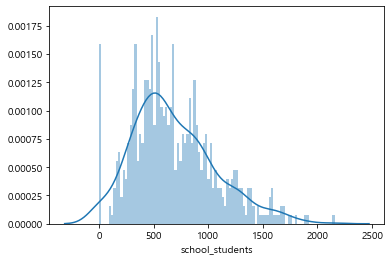

In [32]:
sns.distplot(temp['school_students'],bins=100)

In [33]:
# 학교 학생수가 2000명이 넘는 학교는 한군데로 제거하고 분석을한다 
temp = temp[temp['school_students']<2000]

- 자치구별 세대수와 학교 학생수의 비율을 구하고, 그 비율에 따른 amount값의 분포를 살펴보고자 한다

In [34]:
# 각 자치구 별 세대수
population = pd.read_excel("population.xlsx")
population.drop(['※ 매년 말일자 통계 현황','Unnamed: 4'],axis=1,inplace=True)
population.drop([0,1,2],inplace=True)
population.rename(columns={'Unnamed: 1':'district_name','Unnamed: 2':'총인구수','Unnamed: 3':'세대수'},inplace=True)
population['district_name'] = population.district_name.str.split(' ').str[1]
population['세대수'] = population.세대수.str.replace(',', '').astype('int64')
population = population.drop('총인구수',axis=1)
population.head()

,district_name,세대수
3,종로구,73947
4,중구,62739
5,용산구,110126
6,성동구,135838
7,광진구,164428


In [35]:
df1 = pd.merge(temp,population,how='left',on='district_name')
df1['ratio'] = 0.0
for ind in df1.index:
  a = float(df1['세대수'][ind])
  b = float(df1['school_students'][ind])
  df1['ratio'][ind] = b/a

In [36]:
df1.head()

,index,school_name,school_students,amount,district_name,세대수,ratio
0,0,,0.0,5.449626e+08,강동구,183390,0.0
1,310,,0.0,5.449626e+08,강북구,144277,0.0
2,336,,0.0,5.449626e+08,강서구,262708,0.0
3,341,,0.0,5.449626e+08,광진구,164428,0.0
4,362,,0.0,5.449626e+08,구로구,176568,0.0


- ratio는 각 자치구별 세대수와 학교 학생수의 비율을 구한것 

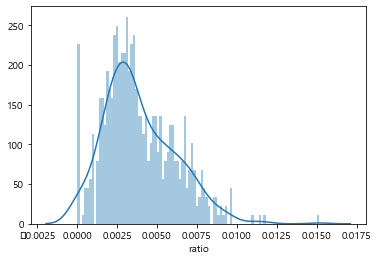

In [37]:
sns.distplot(df1['ratio'],bins=100)

- ratio는 0.00038과 0.015사이
- ratio가 0.015이상인 학교는 한 사례로 제거한다

In [38]:
df1 = df1[df1['ratio']<0.015]

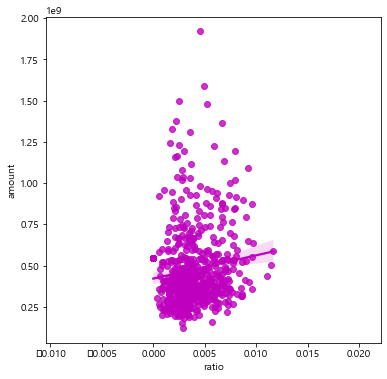

In [39]:
figure,ax1 = plt.subplots()
figure.set_size_inches(6,6) 

sns.regplot(x="ratio",y="amount",data=df1,color="m",ax=ax1)

- ratio가 클수록 아파트의 실거래가가 높아진다
- ratio를 구간별로 나누어 실거래가와의 관계를 살펴본다

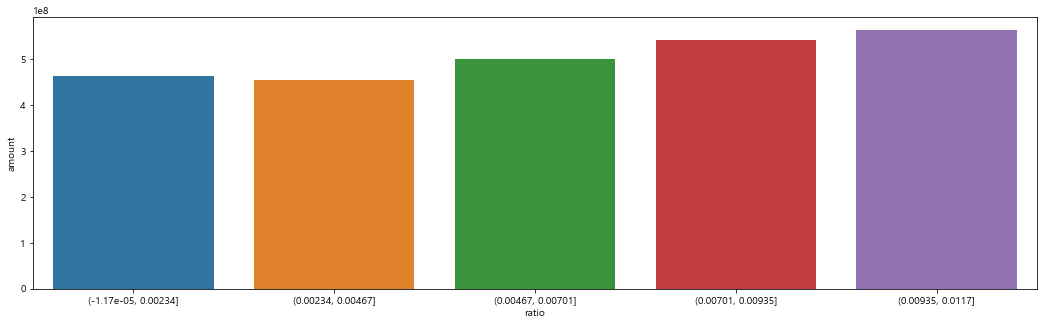

In [40]:
factor = pd.cut(df1.ratio,5)
a = df1.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()


figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="ratio",y="amount",ax=ax1)

- 자치구 세대수 인구 대비 학교 학생수의 비율이 커질수록, amount가 커지는 경향

### 3) 세대당 주차대수

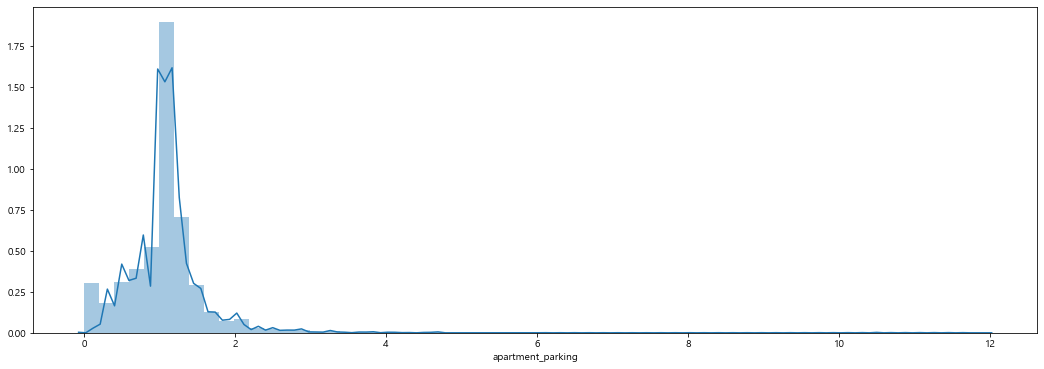

In [41]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 
sns.distplot(df['apartment_parking'],ax=ax1,bins=60)

- 세대당 주차대수는 0~2대 사이에 주로 분포

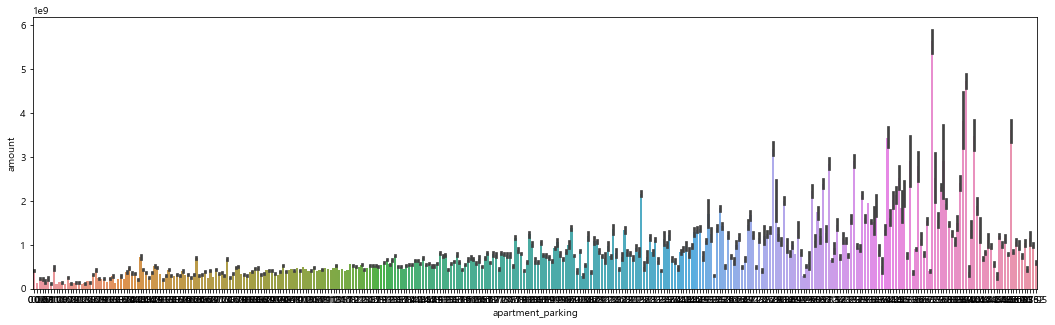

In [42]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=df,x="apartment_parking",y="amount",ax=ax1)

- 세대당 주차대수의 값이 커질수록 amount의 값이 점진적으로 우상향하는 것을 확인할 수 있다

### 4) 건설

In [43]:
df['apartment_builder'].nunique()

2520

- 2520개의 건설사 존재

#### 건설사 apartment_Builder
- 건설사에 따른 2019년도의 거래가를 구해서 거래가의 분포를 살펴보았다 

In [44]:
sample = df.groupby(['apartment_builder','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,apartment_builder,year,amount
3,((주)심원디엔씨),2019,344000000.0
13,(유)25종합건설,2019,325000000.0
24,(유)동호에스제이종합개발,2019,280000000.0
32,(유)호원건설,2019,340000000.0
45,(조한종합),2019,509999999.0


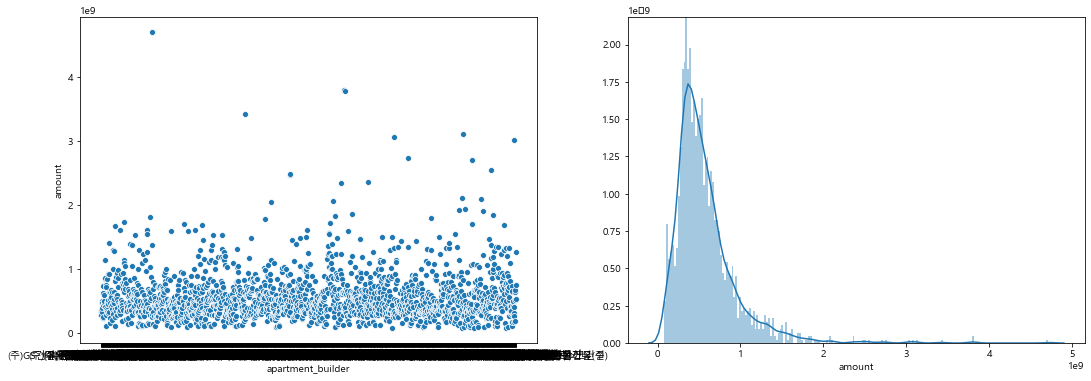

In [45]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.scatterplot(sample_2019['apartment_builder'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=200)

- 건설사별 2019년 아파트 평균 가격을 구하였을 때, 10억 이하의 값으로 편중되어있다 > 제거한다

In [46]:
a = sample_2019[sample_2019['amount']>1000000000]['amount'].count()
b = sample_2019['amount'].count()
num = np.round(a/b*100)

print(f'10억 이상의 값을 가지는 경우는{num}%이다')

10억 이상의 값을 가지는 경우는10.0%이다


#### 건설연도 apartment_build_year

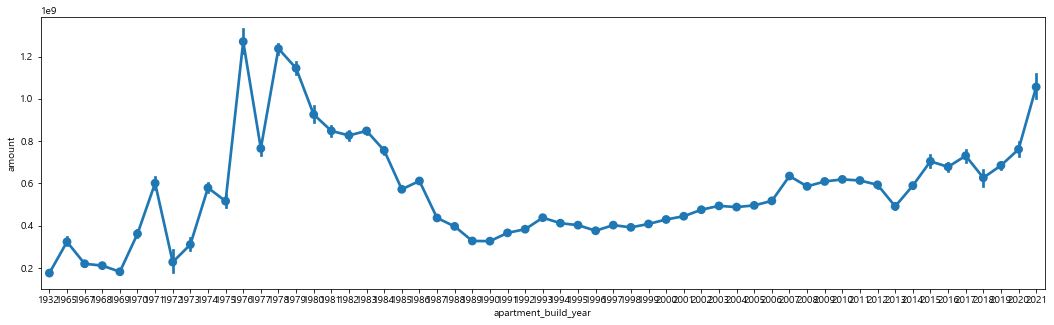

In [47]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.pointplot(data=df,x="apartment_build_year",y="amount",ax=ax1)

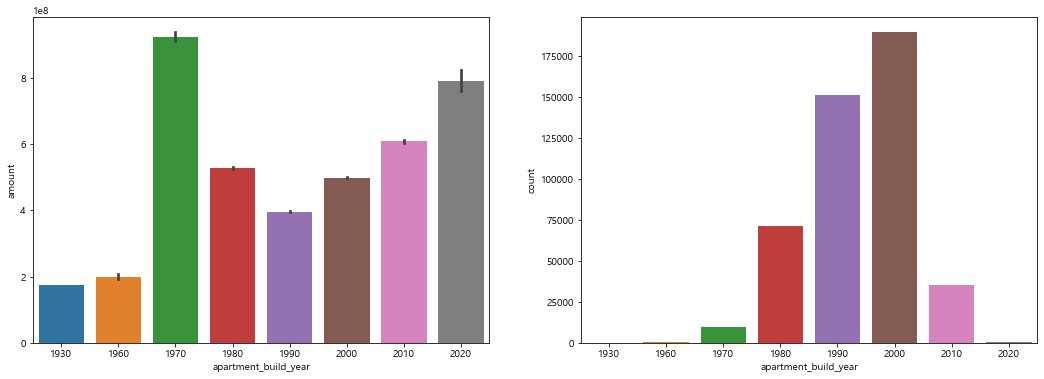

In [48]:
df['apartment_build_year'] = df['apartment_build_year'].apply(lambda x : x - x%10)
a = df['apartment_build_year'].value_counts()
a = pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'index':'apartment_build_year','apartment_build_year':'count'},inplace=True)


figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.barplot(data=df,x="apartment_build_year",y="amount",ax=ax1)
sns.barplot(data=a,x="apartment_build_year",y="count",ax=ax2)

- 1970, 2020년대에 지어진 아파트의 수가 적은거에 비해 amount의 평균이 높다
- 2000년대에 가장 많이 아파트가 지어졌지만, 그에 비해 amount의 평균이 낮음

### 5) 지하철역

In [49]:
df['st_name'].nunique()

296

#### 지하철역에 따른 amount값의 분포 확인
- 지하철역에 따른 2019년도의 거래가를 구해서 거래가의 분포를 살펴보았다 

In [50]:
sample = df.groupby(['st_name','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,st_name,year,amount
13,4.19민주묘지역,2019,3.322311e+08
28,가락시장역,2019,1.131895e+09
43,가산디지털단지역,2019,3.877221e+08
58,가양역,2019,5.530393e+08
73,가오리역,2019,4.011351e+08


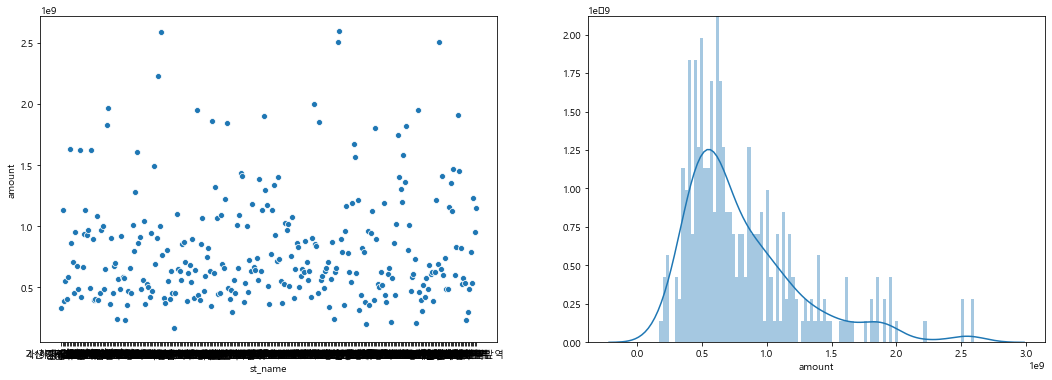

In [51]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6)

sns.scatterplot(sample_2019['st_name'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=100)

- 각 지하철역 근처 아파트의 2019년 거래가 평균을 살펴보았을 때, 가격의 분포가 역에 따라 다양한 값을 갖는다

#### 지하철역 환승역 개수 st_volume

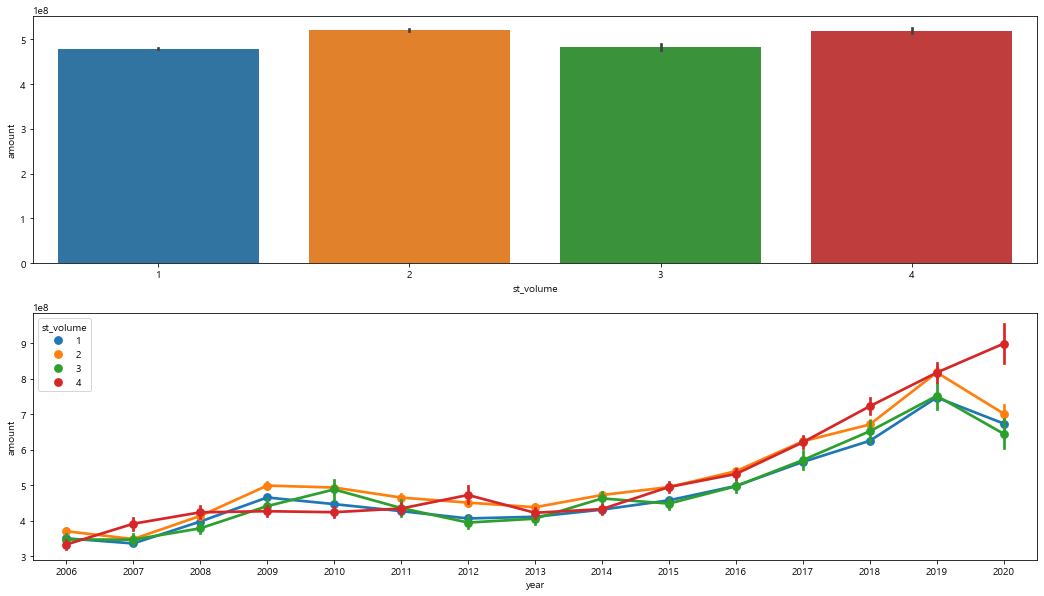

In [52]:
figure,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(18,10) 

sns.barplot(data=df,y='amount',x='st_volume',ax=ax1)
sns.pointplot(data=df,y='amount',x='year',hue='st_volume',ax=ax2)

- 환승역이 4개인 곳의 실거래가가 2014년도 이후부터 꾸준히 증가
- 환승역의 개수 별 거래액이 큰 차이를 보이지 않는다 > 제거 

#### 지하철역과의 거리 st_dist

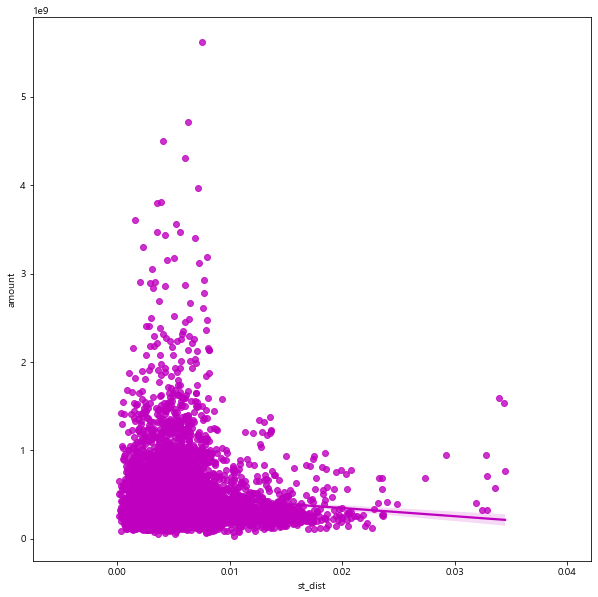

In [53]:
a = df.groupby('st_dist').mean()['amount']
a = pd.DataFrame(a).reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(10,10) 

sns.regplot(x="st_dist",y="amount",data=a,color="m",ax=ax1)

- 가까운 역까지의 거리와 거래액은 음의 상관관계를 보인다 
- 이번에는 거리를 구간별로 나눠서 살펴보자

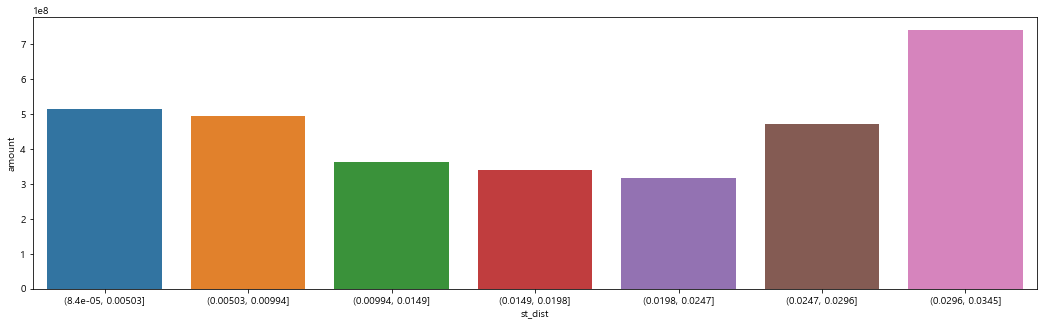

In [54]:
factor = pd.cut(df.st_dist,7)
a = df.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="st_dist",y="amount",ax=ax1)

- 거리가 0.0247 이하인 경우 지하철역에서 거리가 가까울수록 거래가가 비싸지만, 0.0247보다 큰 경우에는 양의 상관관계를 보인다
- 지하철역과 거리가 가장 먼 곳이 가장 높은 평균 거래가를 갖는다

In [55]:
df[df['st_dist']>0.0296]['apartment_addr_town'].drop_duplicates()

436478    평창동
Name: apartment_addr_town, dtype: object

- 지하철역과의 거리가 0.0296보다 큰 지역을 살펴보니, 평창동임을 확인할 수 있었다 > 자가용을 이용하는 동네

#### Feature selecting

- 최종적으로 클러스터링에 'district_id'  'apartmnet_addr_town' 'apartment_build_year' 'apartment_parking' 'school_name' 'school_students' 'st_name' 'st_dist'변수를 사용하기로 결정했다